# Draft Pipeline

## Set Up

In [1]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro, pearsonr
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

# set visualization default
sns.set_theme()

# load data
raw_df = pd.read_csv('../../data/raw/rawdata_new.csv')

# create copy of raw data
processed_df = raw_df.copy()

## Data Prep

### Add predictors

In [2]:
# environment minded
environment_minded_cols = ['GHG_goal', 'env_goal', 'biodiv_goal']
processed_df['environment_minded'] = processed_df[environment_minded_cols].mean(axis=1)

In [3]:
# perceive weather changes
perceive_weather_cols = ['percep_hail', 'percep_drought', 'percep_frost', 'percep_heavyrain', 'percep_longrain', 'percep_heat']
processed_df['perceive_weather_change'] = processed_df[perceive_weather_cols].mean(axis=1)

In [4]:
# anticipate negative consequences
anticipate_negative_cols = ['cons_general', 'cons_farm']
processed_df['anticipate_negative_consequences'] = processed_df[anticipate_negative_cols].mean(axis=1)

In [5]:
# capable implement
capable_cols = ['self_reduc', 'self_act', 'self_cap', 'self_conf', 'self_not']
processed_df['capable_implement'] = processed_df[capable_cols].mean(axis=1)

In [6]:
# social connectedness
social_cols = ['net_name1_imp', 'net_name2_imp', 'net_name3_imp', 'net_name4_imp', 'net_name5_imp', 'net_name6_imp', 'net_name7_imp', 'net_name8_imp', 'net_name9_imp', 'net_name10_imp']
processed_df['social_connectedness'] = processed_df[social_cols].mean(axis=1)

In [7]:
# think measures effective

# create columns that include effectiveness ratings only for applicable mitigations
measure_cols = ['legum', 'conc', 'add', 'lact', 'breed', 'covman', 'comp', 'drag', 'cov', 'plough', 'solar', 'biog', 'ecodr']
for measure in measure_cols:
    measure_eff = measure + '_eff' # effective
    measure_app = measure + '_app' # applicable
    measure_eff_app = measure + '_eff_app' # effective and applicable
    processed_df[measure_app] = [np.NAN if x == 3 else 1 for x in processed_df[measure]]
    processed_df[measure_eff_app] = processed_df[measure_eff] * processed_df[measure_app]

# take average of effectiveness ratings
measures_eff_app_cols = [c + '_eff_app' for c in measure_cols]
processed_df['think_measures_effective'] = processed_df[measures_eff_app_cols].mean(axis=1)

# find record with NAN, change to NA to average rating across farms
nan_row = np.where(processed_df['think_measures_effective'].isna())[0][0]
nan_col = np.where(processed_df.columns == 'think_measures_effective')[0][0]
processed_df.iloc[nan_row, nan_col] = processed_df['think_measures_effective'].mean()

### Add outcome variable

In [8]:
# measures implemented

# calculate proportion of applicable measures implemented
implemented_cols = ['legum', 'conc', 'add', 'lact', 'breed', 'covman', 'comp', 'drag', 'cov', 'plough', 'solar', 'biog', 'ecodr']
processed_df['num_implemented'] = (processed_df[implemented_cols] == 1).sum(axis=1)
processed_df['num_applicable'] = (processed_df[implemented_cols] != 3).sum(axis=1)
processed_df['prop_implemented'] = processed_df['num_implemented'] / processed_df['num_applicable']

## Assumptions Check
I need to check four assumptions; three before fitting my model and one after.

1. *Is the outcome normally distributed?*
    * Hopefully yes.
    * If not, use a non-linear transformation on the outcome or fit a non-linear model.
    * Visual check: plot the distribution.
    * Statistical check: Use a Shapiro Wilk test. Null hypothesis is normal distribution.
2. *Are the predictors correlated?*
    * Hopefully not.
    * If so, combine them with PCA and check again.
    * Visual check: plot a scatterplot matrix and a heatmap of the correlation matrix.
    * Statistical check: use Pearson's or Spearmean correlation coefficient. Use Pearson's if predictors are normal, Spearman if not.
3. *Are there linear relationships between the predictors and the outcome variable?*
    * Hopefully yes.
    * If not, use a non-linear transformation on the predictors or fit a non-linear model.
    * Visual check: plot each predictor against the outcome variable.
4. *Are the errors homoscedastic?*
    * Hopefully yes.
    * If not, calculate standard errors to be robust to heteroscedasticity.
    * Visual check: plot the residuals.

### 1. Is the outcome normally distributed?

<AxesSubplot:xlabel='prop_implemented', ylabel='Count'>

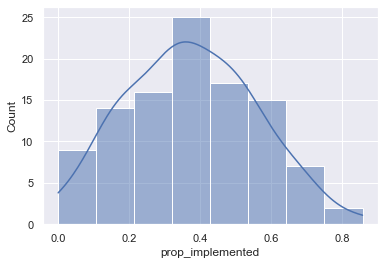

In [9]:
# visual check for normal distribution
sns.set_theme()
sns.histplot(data=processed_df, x='prop_implemented', kde=True)

Visually, the outcome variable seems pretty normal.

In [10]:
# statistical check for normal distribution
shapiro(processed_df['prop_implemented'])

ShapiroResult(statistic=0.9865807294845581, pvalue=0.37496018409729004)

Statistically, the outcome variable seems pretty normal. The null hypothesis of the Shapiro-Wilk test is that the data was drawn from a normal distribution. A test with the p-value above the conventional significance level of 0.05 fails to reject the null hypothesis of normality.

*Conclusion:* Assumption met.

### 2. Are the predictors correlated?

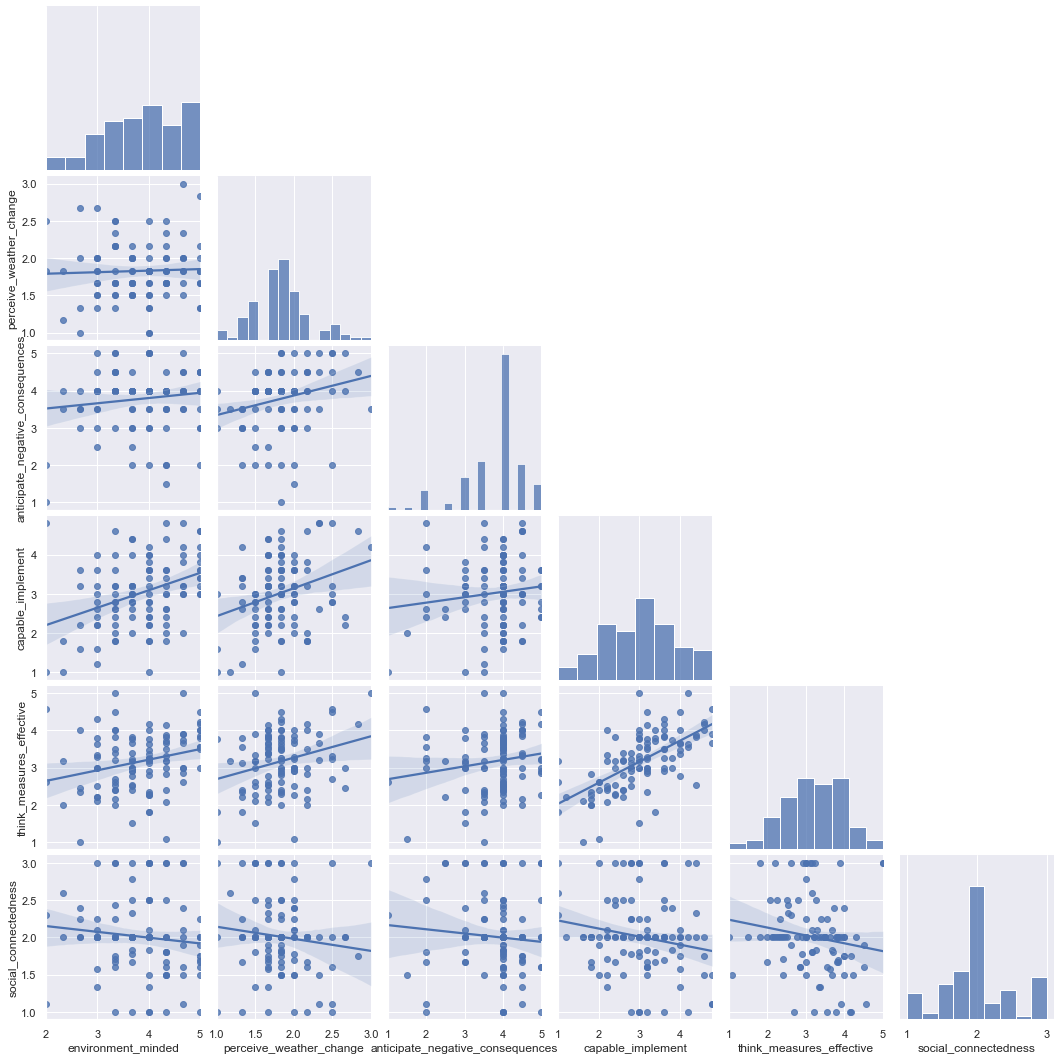

In [11]:
# visual check for correlated predictors
X = processed_df[['environment_minded', 'perceive_weather_change', 'anticipate_negative_consequences', 'capable_implement', 'think_measures_effective', 'social_connectedness']]
sns.pairplot(X, kind='reg', corner=True)

<AxesSubplot:>

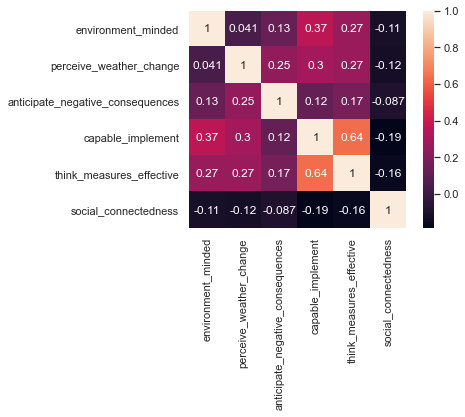

In [12]:
# another visual check for correlated predictors
sns.heatmap(X.corr(), annot=True, square=True)

Visually, the correlation seems low between predictors. The highest correlated variables are `capable_implement` and `think_measures_effective` with a correlation of 0.64. I'll test the statistical significance of that correlatin now.

In [13]:
# statistical check for correlated predictors
pearsonr(processed_df['capable_implement'], processed_df['think_measures_effective'])

(0.6359896967141423, 3.105825606561878e-13)

That p-value is super low! I reject the null hypothesis that the two predictors are not correlated.

*Conclusion:* Assumption NOT met. Need to combine features `capable_implement` and `think_measures_effective`.

### 3. Are there linear relationships between the predictors and the outcome variable?

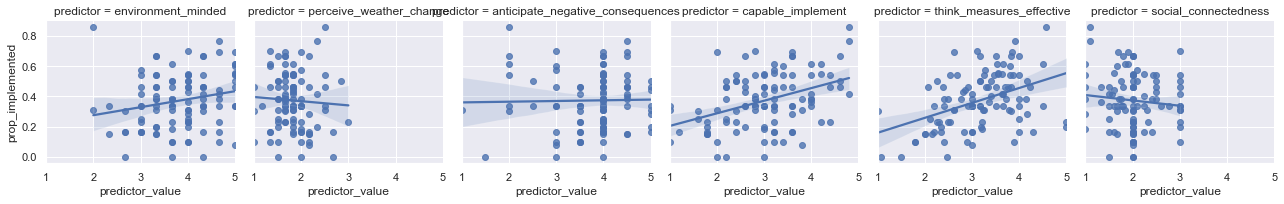

In [14]:
# visual check for linear relationships
vars_df = pd.melt(processed_df, id_vars=['prop_implemented'], value_vars=['environment_minded', 'perceive_weather_change', 'anticipate_negative_consequences', 'capable_implement', 'think_measures_effective', 'social_connectedness'], var_name='predictor', value_name='predictor_value')
g = sns.FacetGrid(vars_df, col='predictor')
g.map(sns.regplot, 'predictor_value', 'prop_implemented')

*Conclusion:* Assumption met.

## Model Fit

In [15]:
Y = processed_df['prop_implemented']
X = processed_df[['environment_minded', 'perceive_weather_change', 'anticipate_negative_consequences', 'capable_implement', 'think_measures_effective', 'social_connectedness']]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()

### 4. Are the errors homoscedastic?

<AxesSubplot:xlabel='prop_implemented_actual', ylabel='residual'>

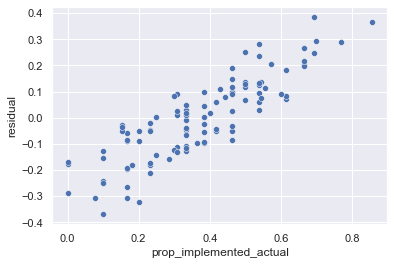

In [16]:
# visual check for homoscedastic errors
# plot residuals against outcome variable
residual_df = pd.DataFrame({'prop_implemented_actual':processed_df['prop_implemented'],
                            'residual':results.resid,
                            'prop_implemented_predicted':results.fittedvalues})
sns.scatterplot(data=residual_df, x='prop_implemented_actual', y='residual')

There is a positive relationship between the residuals and the outcome variable, but the variance looks consistent across the range of actual outcome values.

*Conclusion:* Assumption met.

## Metrics and Visualizations

<AxesSubplot:xlabel='prop_implemented_actual', ylabel='prop_implemented_predicted'>

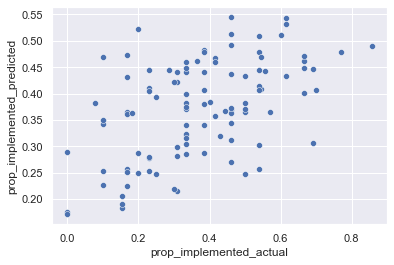

In [17]:
# visual check of model fit
sns.scatterplot(data=residual_df, x='prop_implemented_actual', y='prop_implemented_predicted')

There seems to be a linear relationship between model predictions and actual values, but it is not a tight relationship. This suggests the model captures some of the variation in the data.

In [18]:
# view summary table
Stargazer([results])

*Model interpretation*
* The model's R-squared is 0.259, which means the model accounts for 25.9% of the variance in the outcome variable.
* The residual standard error is 0.161, which means that the model mispredicts proportion of applicable measures implemented by about one sixth.
* The F statistic has a p-value less than 0.01, which is highly statistically significant.
These three statistics suggest that my model captures a quarter of the variance in the outcome, but is highly significant.

*Coefficient interpretation*
* Anticipate negative consequences has a statistically insignificant p-value greater than 0.1.
* Capable implement has a statistically significant p-value less than 0.5. The coefficient estimate is +0.052, which is interpreted as a 0.52 increase on average for the responses to questions about farmers feeling able to impact climate change is related to a 10% increase in the proportion of applicable mitigations implemented. This supports my hypothesis. Also, note that this variable is highly correlated with think measures effective.
* Environment minded has a statistically insignificant p-value greater than 0.1.
* Perceive weather change has a statistically significant p-value less than 0.5. THe coefficient estimate is -0.106, which is interpreted as a 1.06 decrease on average in response to questions about perceiving weather changes is related to a 10% increase in the proportion of applicable mitigations implemented. This does not support my hypothesis.
* Social connectedness  has a statistically insignificant p-value greater than 0.1.
* Think measures effective has a highly statistically significant p-value less than 0.01. The coefficient estimate is +0.072, which is interpreted as a 0.72 increase on average for responses to questions about farmers thinking mitigations are effective is related to a 10% increase in the proportion of applicable mitigations implemented. This supports my hypothesis. Also, note that this variable is highly correlated with capable implement.

*Keep in mind*
* Predictor and outcome variables are all based on self-reported data.
* This analysis was run on survey data, not experimental data or with a causal approach, so all relationships observed between the predictors and outcome variable are correlation, not causation.
